In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
import enum
import sys


# Helpers

In [2]:
class TypeOfLearningRate(enum.Enum):
    const = 0
    timeBased = 1


class ConditionOfDichotomy(enum.Enum):
    normal = 0
    wolfe = 1

# Configuring constants

In [3]:
minValue = -10
maxValue = 10
totalNumber = 1000

eps = 10**-9
delta = 0.1 * eps
deltaDiff = 10**-9
c1 = 0.1
c2 = 1 - c1
sys.setrecursionlimit(5000)

## Functions
$f(x, y) = x^2 y^2 + 3xy - 5$ <br>
$1. \quad f(x, y) = x^2 + y^2$ <br>
$2. \quad f(x, y) = x^2 + (y - x)^2$ <br>
$3. \quad f(x, y) = x^2 + y^2 + xy$

In [4]:
def function(x, y):
    return x**2 * y**2 + 3 * x * y - 5

def dxFunction(x, y, abstractFunction):
    return (abstractFunction(x + deltaDiff, y) - abstractFunction(x, y)) / deltaDiff

def dyFunction(x, y, abstractFunction):
    return (abstractFunction(x, y + deltaDiff) - abstractFunction(x, y)) / deltaDiff
  
def function1(x, y):
    return x**2 + y**2

def function2(x, y):
    return x**2 + (y - x)**2

def function3(x, y):
    return x**2 + y**2 + x*y

def gradient(x, y, abstractFunction):
    return np.array([dxFunction(x, y, abstractFunction), dyFunction(x, y, abstractFunction)])

def phi(startPoint, p, alpha, abstractFunction):
    x = startPoint[0]
    y = startPoint[1]
    px = p[0]
    py = p[1]
    return abstractFunction(x - alpha * px, y - alpha * py)

def nextPoint(coordinates, lr, abstractFunction):
    x = coordinates[0]
    y = coordinates[1]
    return coordinates - lr * gradient(x, y, abstractFunction)

def checkIfLessThanEps(a, b):
    square = np.square(a - b)
    sumSquare = np.sum(square)
    distance = np.sqrt(sumSquare)
    return distance < eps

def getGraph(pointOfDescent, abstractFunction):
    z = abstractFunction(x, y)
    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, alpha=0.6)
    xGD, yGD = [], []
    for xi, yi in pointOfDescent:
        xGD.append(xi)
        yGD.append(yi)
    xGD = np.array(xGD)
    yGD = np.array(yGD)
    zGD = function(xGD, yGD)
    ax.scatter(xGD, yGD, zGD)

## GDS (Task 1-2)
Gradient descent calculates gradient value on each iteration 
depending on the type of changing learning rate, algorithm either leaves it still (constant value of learning rate) or changes basing on the number of iterations, the formula is: <br>
$lr = lr \cdot \dfrac{1}{1 + decay \cdot ind}$, where $\textbf{decay}$ is some constant, and $\textbf{ind}$ is current number of iteration <br>
The stopping criteria is situation, where absolute difference between neighbour values of function is lower than some epsilon: $eps = 10^{-6}$ <br> <br>
found() - runs GDS several times to see, which decay fits the most <br>
Decay changes from one epoch to another by formula: $decay = \dfrac{lr}{epoch}$ <br>
This means that the next epoch of GDS will be more accurate, but it's more likely to calculate longer


In [5]:
def gradientDescent(lr, decay, typeOfLearningRate, startingPoint, abstractFunction):
    descentPoints = []
    descentPoints.append(startingPoint)
    descentPoints.append(nextPoint(descentPoints[0], lr, abstractFunction))
    ind = 1
    while not checkIfLessThanEps(descentPoints[ind - 1], descentPoints[ind]):
        if typeOfLearningRate == TypeOfLearningRate.timeBased:
            lr *= (1. / (1. + decay * ind))
        descentPoints.append(nextPoint(descentPoints[ind], lr, abstractFunction))
        ind += 1
    # print("Gradient descent finished at the point of: ", descentPoints[ind], "decay = ", decay)
    # print("Number of iterations: ", ind)
    return (descentPoints, ind)

def found(abstractFunction, typeOfLearningRate):
    minRes = 100
    startingPoint = np.array([random.randint(minValue, maxValue), random.randint(minValue, maxValue)])
    points = []
    for epoch in range(1, 100):
        lr = 0.02
        decay = lr / epoch
        points, res = gradientDescent(lr, decay, typeOfLearningRate, startingPoint, abstractFunction)
        if minRes > res:
            minRes = res
    print("GDS finished at:", points[len(points) - 1], "within", len(points), "iterations")
    getGraph(points, abstractFunction)
    return (minRes, decay)

### Execution of GDS on function

GDS finished at: [1.28849019e+17 1.28849019e+17] within 6 iterations


(5, 0.00020202020202020202)

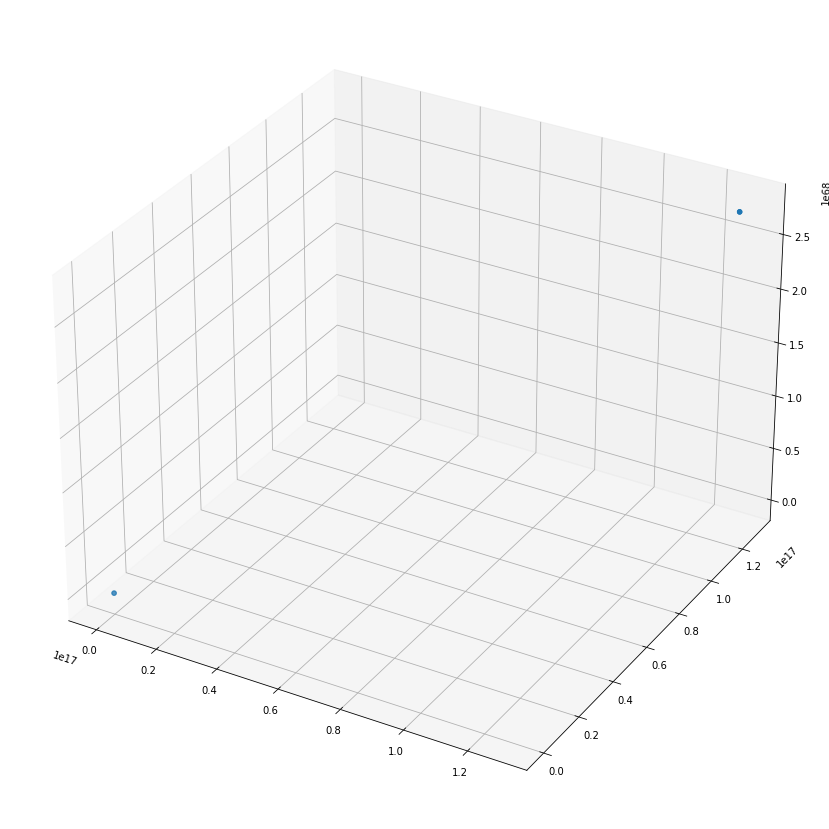

In [6]:
fig = plt.figure()
fig.set_size_inches(15, 15)
ax = plt.axes(projection='3d')

x = np.linspace(minValue, maxValue, totalNumber)
y = np.linspace(minValue, maxValue, totalNumber)
x, y = np.meshgrid(x, y)

found(function, TypeOfLearningRate.const)

# Dichotomy and Wolfe condition (Task 3-4)
The main idea is to find new learning rate constant on every iteration using one-dimensional search
and using this alpha do the next iteration of GDS.

In [7]:
def dichotomy(a, b, startPoint, p, abstractFunction, condition):
    middle = (a + b) / 2
    if (condition == ConditionOfDichotomy.normal):
        if (abs(a - b) < eps):
            return middle
    else:
        if (wolfeConditions(abstractFunction, startPoint, middle, p)):
            return middle
    x1 = middle - delta
    x2 = middle + delta
    if (phi(startPoint, p, x1, abstractFunction) < phi(startPoint, p, x2, abstractFunction)):
        return dichotomy(a, x2, startPoint, p, abstractFunction, condition)
    elif (phi(startPoint, p, x1, abstractFunction) > phi(startPoint, p, x2, abstractFunction)):
        return dichotomy(x1, b, startPoint, p, abstractFunction, condition)
    else:
        return dichotomy(x1, x2, startPoint, p, abstractFunction, condition)

def findSegment(startPoint, abstractFunction, condition):
    phi0 = abstractFunction(startPoint[0], startPoint[1])
    p = gradient(startPoint[0], startPoint[1], abstractFunction)
    alpha = 0.0001
    phi1 = phi(startPoint, p, alpha, abstractFunction)
    if phi0 > phi1: 
        alpha *= 2
        phi2 = phi(startPoint, p, alpha, abstractFunction)
        while phi2 < phi1: 
            alpha *= 2
            phi2 = phi(startPoint, p, alpha, abstractFunction)
    res = dichotomy(0, alpha, startPoint, p, abstractFunction, condition)
    return startPoint - res * p
 
def gradientDescentDichotomy(startingPoint, abstractFunction, condition):
    descentPoints = []
    descentPoints.append(startingPoint)
    descentPoints.append(findSegment(startingPoint, abstractFunction, condition))
    ind = 1
    while not checkIfLessThanEps(descentPoints[ind - 1], descentPoints[ind]):
        segment = findSegment(descentPoints[ind], abstractFunction, condition)
        descentPoints.append(segment)
        ind += 1
    print("Gradient descent dichotomy finished at the point of: ", descentPoints[ind])
    print("Number of iterations: ", ind)
    return descentPoints

def wolfeConditions(abstractFunction, startPoint, alpha, p):
    point = startPoint - alpha * p
    return (abstractFunction(point[0], point[1]) <= abstractFunction(startPoint[0], startPoint[1]) + alpha * c1 * np.dot(p, -p)) \
           and (np.dot(gradient(point[0], point[1], abstractFunction), -p)) >= c2 * np.dot(p, -p)

## Draw graph
This part of the code draws the function itself and marks dots of the gradient descent on it

In [8]:
def main(abstractFunction):
    z = abstractFunction(x, y)
    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, alpha=0.6)

    # found(abstractFunction)
    # print(np.array([1, 2]) * 3.3)
    point = np.array([random.randint(minValue, maxValue), random.randint(minValue, maxValue)])
    pointsOfDichotomy = gradientDescentDichotomy(point, abstractFunction, ConditionOfDichotomy.wolfe)
    print(pointsOfDichotomy)

    xD = []
    yD = []
    for xi, yi in pointsOfDichotomy:
        xD.append(xi)
        yD.append(yi)
    xD = np.array(xD)
    yD = np.array(yD)
    zD = abstractFunction(xD, yD)
    for i in range(1, len(xD)):
        ax.plot([xD[i], xD[i - 1]], [yD[i], yD[i - 1]], zs=[zD[i], zD[i - 1]], color='red')
    ax.scatter(xD[0], yD[0], zD[0], linewidths=3, color='red')
    ax.scatter(xD[len(xD) - 1], yD[len(yD) - 1], zD[len(zD) - 1], linewidths=3, color='red')
    # ax.scatter(xD, yD, zD, color='red')

    plt.show()

main(abstractFunction=function2)

RecursionError: maximum recursion depth exceeded while calling a Python object